# TP1 - NLP2
## Alumno: Jorge Heyul Chavez Arias
# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:

## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

from datasets import load_dataset
from datasets import load_from_disk


c:\Users\heyul\anaconda3\envs\torchcuda13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Descargando el conjunto de datos

In [ ]:
#ds = load_dataset("wikimedia/wikipedia", "20231101.es", split="train")
#ds.save_to_disk("C:/datasets/wikipedia-es")

Saving the dataset (13/13 shards): 100%|██████████| 1841155/1841155 [00:03<00:00, 529687.06 examples/s]


In [16]:
ds = load_from_disk("./wikipedia-es")

texts = ds["text"]
 
raw_text = "\n\n".join(texts)

text = raw_text[:1_000_000]

print("Cantidad de caracteres:", len(text))
print(text[:2000])

Cantidad de caracteres: 1000000
Andorra, oficialmente Principado de Andorra () es un micro-Estado soberano sin litoral ubicado en el suroeste de Europa, entre España y Francia, en el límite de la península ibérica. Se constituye en Estado independiente, de derecho, democrático y social, cuya forma de gobierno es el coprincipado parlamentario. Su territorio está organizado en siete parroquias, con una población total de 79 877 habitantes a 28 de febrero de 2022. Su capital es Andorra la Vieja.

Con sus 468 km² de extensión territorial, Andorra es el micro-Estado más grande de Europa y está situado en los Pirineos, entre España y Francia; tiene una altitud media de 1996ms.n.m. Limita por el sur con España —con la provincia catalana de Lérida— y por el norte con Francia —con los departamentos de Ariège y Pirineos Orientales (Occitania)—. Pertenece culturalmente a la Europa latina.

Su sistema político es una democracia parlamentaria cuyos jefes de Estado son los copríncipes de Andorra: el

# Codificación basada en caracteres

In [22]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# modelo BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)

trainer = trainers.BpeTrainer(
    vocab_size=8000,           
    min_frequency=2,
    special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"]
)

def batch_iterator(batch_size=1000):
    for i in range(0, len(text), batch_size * 1000):
        yield text[i : i + batch_size * 1000]

tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

tokenizer.save("tokenizer_es_bpe.json")

print("Tokenizer entrenado y guardado en tokenizer_es_bpe.json")
print("Tamaño del vocabulario:", tokenizer.get_vocab_size())

Tokenizer entrenado y guardado en tokenizer_es_bpe.json
Tamaño del vocabulario: 8000


In [24]:
from tokenizers import Tokenizer, decoders
import torch
 
tokenizer = Tokenizer.from_file("tokenizer_es_bpe.json")
tokenizer.decoder = decoders.ByteLevel() 

# encode/decode  
def encode(s: str):
    return tokenizer.encode(s).ids

def decode(ids): 
    return tokenizer.decode(ids)

vocab_size = tokenizer.get_vocab_size()
print("vocab_size (BPE):", vocab_size)


data_ids = encode(text)
data = torch.tensor(data_ids, dtype=torch.long)
print("Cantidad de tokens (subpalabras):", len(data))

split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]


vocab_size (BPE): 8000
Cantidad de tokens (subpalabras): 251862


# Cargadores de datos

In [25]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [26]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 512 #8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 4
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 512, 'n_embd': 64, 'n_head': 4, 'n_layer': 4, 'dropout': 0.1, 'vocab_size': 8000, 'bias': True, 'ff_class': None, 'moe': None}


In [27]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

In [28]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [30]:
##### qq
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [31]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [32]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [33]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = m #torch.compile(m)

In [35]:
optimizer = AdamW(model.parameters(), lr=1e-3)       
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)    
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5

# Entrenamiento

In [36]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 5.54181: 100%|██████████| 442/442 [00:25<00:00, 17.38it/s]


Época 1 - pérdida de entrenamiento: 5.5350


val_loss 6.53903: 100%|██████████| 49/49 [00:01<00:00, 26.38it/s]


Época 1 - pérdida de validación: 6.0409


loss 4.97400: 100%|██████████| 442/442 [00:24<00:00, 18.26it/s]


Época 2 - pérdida de entrenamiento: 4.9780


val_loss 6.37848: 100%|██████████| 49/49 [00:01<00:00, 32.90it/s]


Época 2 - pérdida de validación: 5.8374


loss 4.72055: 100%|██████████| 442/442 [00:25<00:00, 17.08it/s]


Época 3 - pérdida de entrenamiento: 4.7306


val_loss 6.37269: 100%|██████████| 49/49 [00:01<00:00, 32.53it/s]


Época 3 - pérdida de validación: 5.7933


loss 4.60047: 100%|██████████| 442/442 [00:25<00:00, 17.45it/s]


Época 4 - pérdida de entrenamiento: 4.5971


val_loss 6.37914: 100%|██████████| 49/49 [00:01<00:00, 33.23it/s]


Época 4 - pérdida de validación: 5.7817


loss 4.51397: 100%|██████████| 442/442 [00:25<00:00, 17.59it/s]


Época 5 - pérdida de entrenamiento: 4.5074


val_loss 6.39602: 100%|██████████| 49/49 [00:01<00:00, 31.96it/s]

Época 5 - pérdida de validación: 5.7825
Entrenamiento completo.


### Prueba rápida

In [37]:
generate("El es", max_new_tokens=100,use_cache=True) 

' El es el planma, durante el trigo y el continente por el propiolana es alrededor de oeste y al secremora (incluyendo 3 media) produjo), siendo supera (cerca de 2001).\n Oceanía, Estados Unidos \n\n\nEn el mestiza adeudo, María Matute aparece es el valle que la Argentina resultúaria una región la Patagonia argentina A Plata del ordenador, este colombiano, pasando por medio. En 19186 fue de noviembre por Observaolo, a realizar porque a quien aplica'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [38]:

@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    mode: str = "greedy",         # "greedy", "temperature", "top_k", "top_p"
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:
  
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long, device=device)[None, :] 
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        
        logits = logits[:, -1, :]  
 
        # MODO GREEDY
        if mode == "greedy":
            next_token = torch.argmax(logits, dim=-1, keepdim=True)  

        else:
            if temperature is None or temperature <= 0: 
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else: 
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)  # (1, vocab_size)

         
                # MODO TOP-P
                if mode == "top_p":
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                    mask = cumulative_probs > top_p
                    mask[..., 0] = False  # el más probable
                    sorted_probs = sorted_probs.masked_fill(mask, 0.0)

                    sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

                    next_token_sorted = torch.multinomial(sorted_probs, num_samples=1)  
                    next_token = sorted_indices.gather(-1, next_token_sorted)  

               
                # MODO TOP-K
                elif mode == "top_k":
                    vocab_size = probs.size(-1)
                    k = min(top_k, vocab_size)

                    # top-k tokens
                    top_k_probs, top_k_indices = torch.topk(probs, k=k, dim=-1) 
                    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True) 
                    next_token_in_topk = torch.multinomial(top_k_probs, num_samples=1)   
                    next_token = top_k_indices.gather(-1, next_token_in_topk)   

               
                # MODO TEMPERATURE
                else:  
                    next_token = torch.multinomial(probs, num_samples=1) 

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [42]:
import time

prompt = "El hombre con camisa roja camina en la casa"

def timed_generate(label, func):
    print(label)
    start = time.time()
    out = func()
    end = time.time()
    print(f"Tiempo: {end - start:.4f} segundos")
    print(out)
    print("\n")


# SOFTMAX 
timed_generate(
    "Softmax (sampling por defecto):",
    lambda: generate(prompt, max_new_tokens=50, use_cache=True)
)

# GREEDY
timed_generate(
    "Greedy:",
    lambda: generateV2(prompt, max_new_tokens=50, mode="greedy")
)

# TEMPERATURE
timed_generate(
    "Temperature (1.5):",
    lambda: generateV2(prompt, max_new_tokens=50, mode="temperature", temperature=1.5)
)

# TOP-K
timed_generate(
    "Top-k (20):",
    lambda: generateV2(prompt, max_new_tokens=50, mode="top_k", top_k=20, temperature=1.0)
)

# TOP-P
timed_generate(
    "Top-p (0.9):",
    lambda: generateV2(prompt, max_new_tokens=100, mode="top_p", top_p=0.9, temperature=1.0)
)


Softmax (sampling por defecto):
Tiempo: 0.5777 segundos
 El hombre con camisa roja camina en la casadores de partidas de trampiada y propiedades y se considera probables exceran el llamado AmigaOS «cuano impincoporable en Múnichpenía entramentos que indica no no en las bases sofistyen de esa actividad de distinguir


Greedy:
Tiempo: 0.4551 segundos
 El hombre con camisa roja camina en la casa de la región.

En la población de la población de la población de la población de la población de la población de la población de la población.

En la población de la población de la población de la población de la población de la


Temperature (1.5):
Tiempo: 0.5699 segundos
 El hombre con camisa roja camina en la casa Baadorgo unos tierras profesiongo Bec Veronismo (2000 (13 di corte naok masculvistion; utilizó húme). ser voluntarios de péptidos cada�americano en manosmismo, toma uno'-emvi esenO formado Powerba


Top-k (20):
Tiempo: 0.5752 segundos
 El hombre con camisa roja camina en la casa de 

## Conclusiones

- Se implementaron y compararon distintos métodos de decodificación: greedy, muestreo por temperatura, top-k y top-p, evaluando su impacto en la diversidad del texto generado y en el tiempo de inferencia.

- Se reemplazó el tokenizador basado en caracteres por un tokenizador Byte Pair Encoding (BPE), lo que produjo una mejora significativa en la generación. Con BPE, el modelo genera palabras más coherentes y reduce drásticamente la aparición de términos inexistentes, problema frecuente con la tokenización a nivel de caracteres.

- El método greedy resultó ser el más rápido (≈ 0.45 s), pero presenta una fuerte tendencia a bucles repetitivos, limitando la diversidad del texto generado.

- El muestreo con temperature (1.5) incrementa la variabilidad del texto manteniendo tiempos de inferencia similares al muestreo por defecto (≈ 0.57 s), aunque puede introducir ruido léxico cuando la temperatura es elevada.

- El método top-k (k=20) logra un buen equilibrio entre coherencia y diversidad (≈ 0.57 s), generando secuencias más estructuradas y con menor repetición que greedy.

- Top-p (p=0.9) produce las secuencias más variadas y naturales, al seleccionar dinámicamente el conjunto de tokens más probables, aunque a costa de un mayor tiempo de inferencia (≈ 1.27 s).

- En conjunto, la combinación de BPE + métodos de muestreo (top-k / top-p) mejora notablemente la calidad del texto generado frente al modelo original con tokenización por caracteres y decodificación greedy.

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [43]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "config.moe must be set for MoE"
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [44]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:

        B, T, D = x.shape
        N = B * T  # número total de tokens

        x_flat = x.view(N, D)

        # 1) Logits de gating para cada token y experto
        gate_logits = self.gate(x_flat)            # [N, num_experts]
        gate_probs = F.softmax(gate_logits, dim=-1)  # [N, num_experts]

        # 2) Seleccionar top-k expertos por token
        num_experts = len(self.experts)
        k = min(self.args.num_experts_per_token, num_experts)

        topk_vals, topk_idx = torch.topk(gate_probs, k=k, dim=-1)  # [N, k]

        # 3) Inicializar salida acumulada
        out_flat = torch.zeros_like(x_flat)  # [N, D]

        # 4) Para cada "slot" de experto (entre los top-k)
        for slot in range(k):
            # IDs de experto seleccionados en este slot para cada token
            expert_ids_slot = topk_idx[:, slot]    # [N]
            expert_w_slot = topk_vals[:, slot]     # [N]

            # Para cada experto concreto
            for expert_id, expert in enumerate(self.experts):
                # Tokens que eligieron ESTE experto en ESTE slot
                mask = (expert_ids_slot == expert_id)  # [N]

                if not mask.any():
                    continue

                # Tokens que van a este experto
                x_e = x_flat[mask]           # [N_e, D]
                y_e = expert(x_e)            # [N_e, D]

                # Peso del gate para esos tokens
                w = expert_w_slot[mask].unsqueeze(-1)  # [N_e, 1]

                # Acumular salida ponderada
                out_flat[mask] += y_e * w

        # 5) Volver a forma [B, T, D]
        out = out_flat.view(B, T, D)
        return out

In [45]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "config.moe must be set before using MoEFFN"
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)


## Añadiendo MoE a la configuración

In [49]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=6, num_experts_per_token=2)

# Entrenamiento de TinyGPT‑MoE

In [50]:
m_moe = TinyGPT(config).to(device)
model_moe = m_moe #torch.compile(m)

In [51]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 4

In [52]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 5.37295: 100%|██████████| 442/442 [01:59<00:00,  3.70it/s]


Época 1 - pérdida de entrenamiento: 5.3697


val_loss 6.50935: 100%|██████████| 49/49 [00:07<00:00,  6.84it/s]


Época 1 - pérdida de validación: 5.9338


loss 4.74988: 100%|██████████| 442/442 [02:40<00:00,  2.75it/s]


Época 2 - pérdida de entrenamiento: 4.7430


val_loss 6.38405: 100%|██████████| 49/49 [00:06<00:00,  7.68it/s]


Época 2 - pérdida de validación: 5.7348


loss 4.46498: 100%|██████████| 442/442 [02:04<00:00,  3.56it/s]


Época 3 - pérdida de entrenamiento: 4.4639


val_loss 6.38870: 100%|██████████| 49/49 [00:04<00:00, 11.00it/s]


Época 3 - pérdida de validación: 5.6822


loss 4.31248: 100%|██████████| 442/442 [01:59<00:00,  3.69it/s]


Época 4 - pérdida de entrenamiento: 4.3146


val_loss 6.40748: 100%|██████████| 49/49 [00:04<00:00, 10.63it/s]

Época 4 - pérdida de validación: 5.6810
Entrenamiento completo.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [53]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

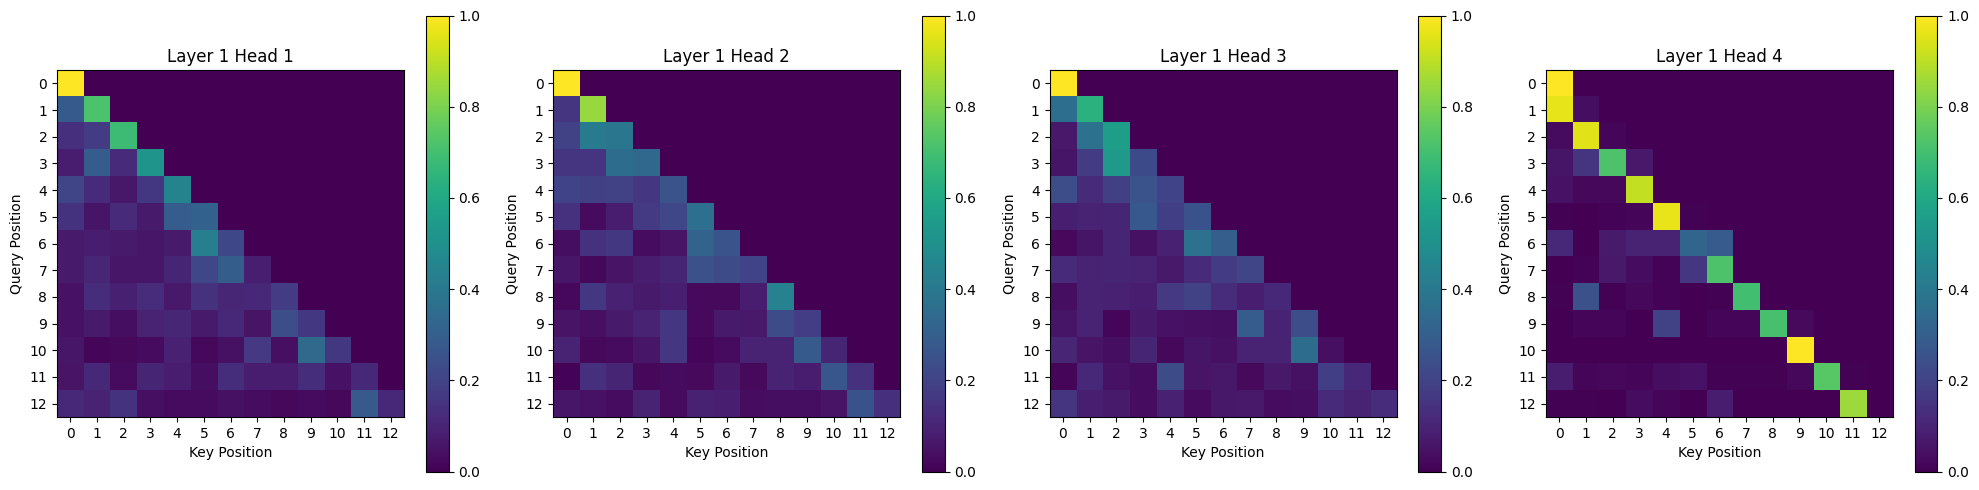

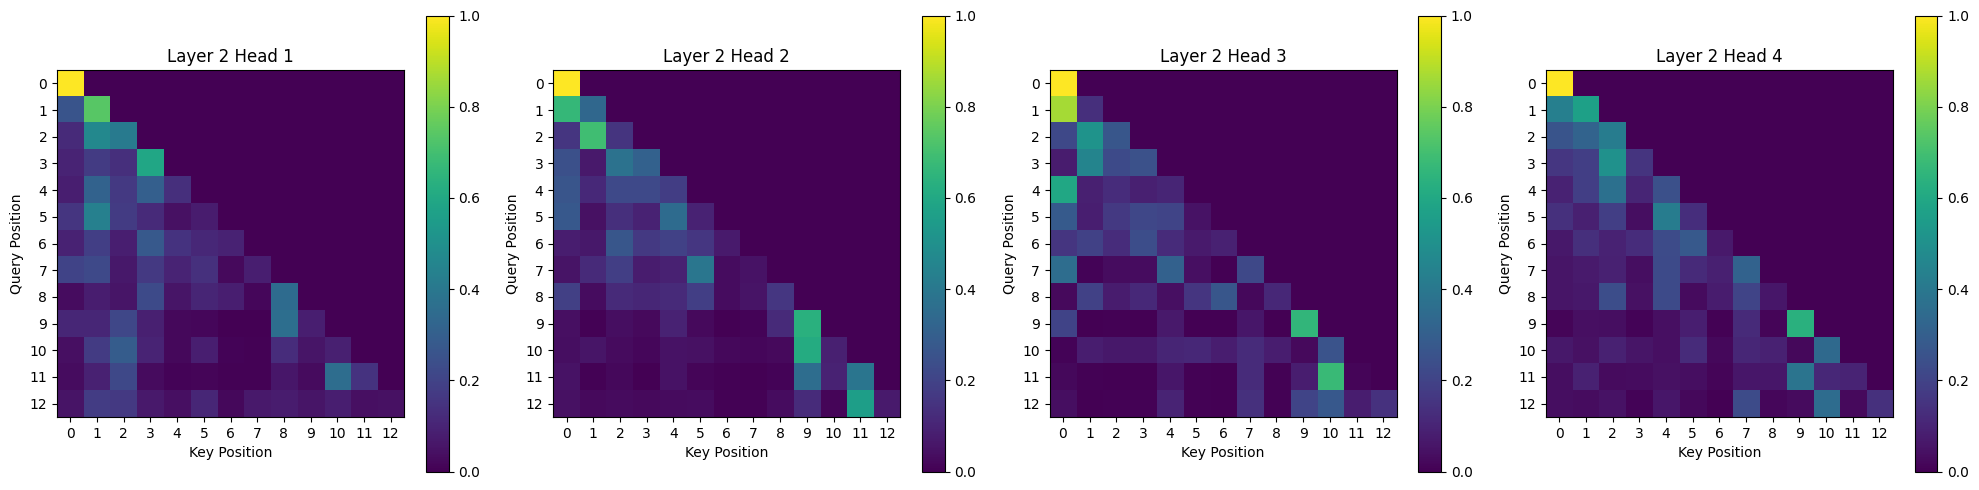

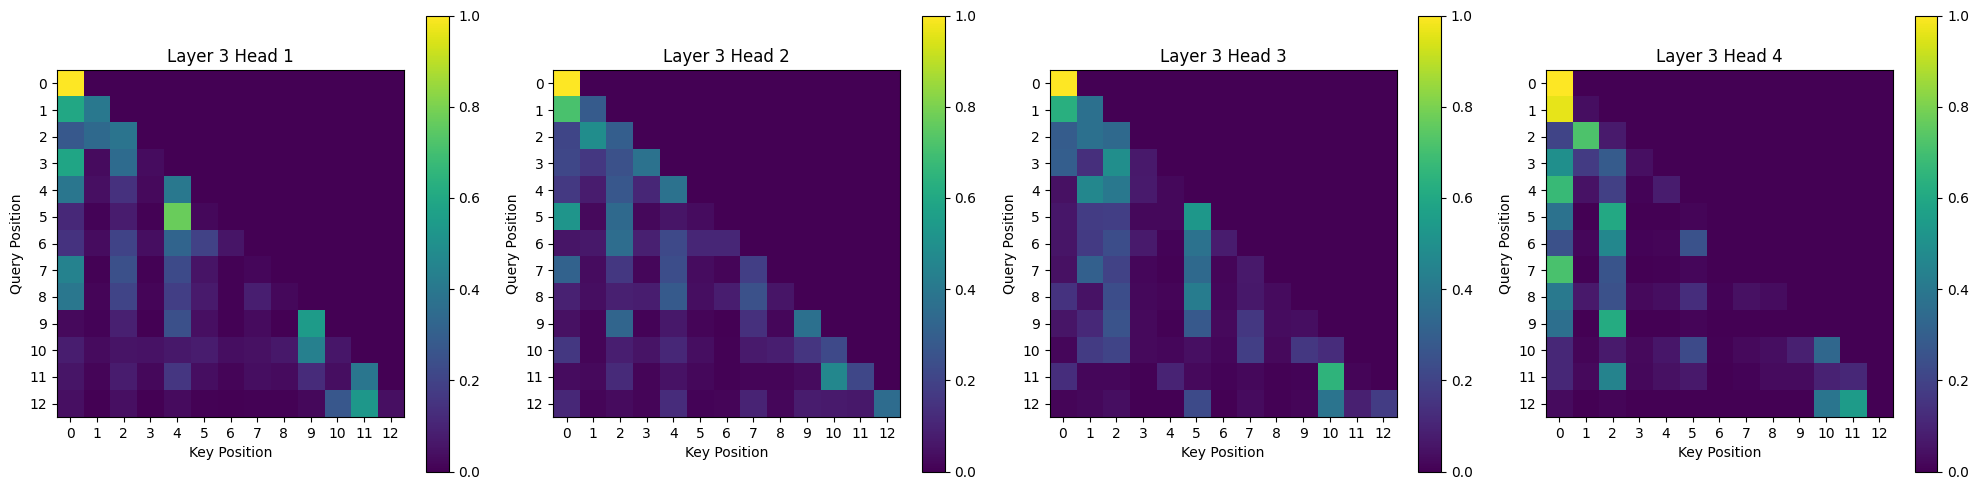

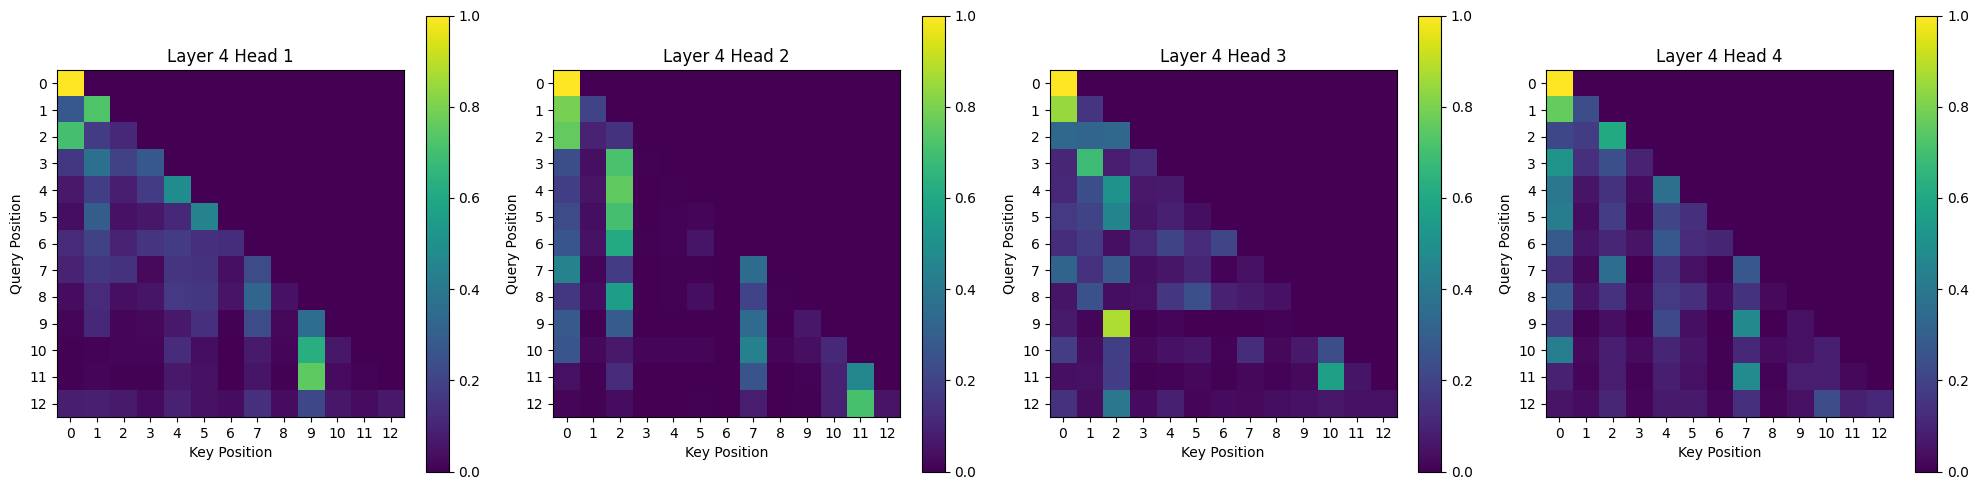

In [54]:
prompt = "El hombre con camisa roja camina en la casa"
visualize_attention(model, prompt)

In [60]:
model = model_moe

@torch.no_grad()
def generateV3(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    mode: str = "greedy",         # "greedy", "temperature", "top_k", "top_p"
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:
  
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long, device=device)[None, :] 
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        
        logits = logits[:, -1, :]  

        # MODO GREEDY
        if mode == "greedy": 
            next_token = torch.argmax(logits, dim=-1, keepdim=True)   

        else: 
            if temperature is None or temperature <= 0: 
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else: 
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)   

                # MODO TOP-P 
                if mode == "top_p": 
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
 
                    mask = cumulative_probs > top_p
                    mask[..., 0] = False  #   más probable
                    sorted_probs = sorted_probs.masked_fill(mask, 0.0)
 
                    sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
 
                    next_token_sorted = torch.multinomial(sorted_probs, num_samples=1)   
                    
                    next_token = sorted_indices.gather(-1, next_token_sorted)   
  
                # MODO TOP-K 
                elif mode == "top_k":
                    vocab_size = probs.size(-1)
                    k = min(top_k, vocab_size)
 
                    top_k_probs, top_k_indices = torch.topk(probs, k=k, dim=-1)
                  
                    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
               
                    next_token_in_topk = torch.multinomial(top_k_probs, num_samples=1)  
                    next_token = top_k_indices.gather(-1, next_token_in_topk)   

 
                # MODO TEMPERATURE 
                else:   
                    next_token = torch.multinomial(probs, num_samples=1)  
 
        idx = torch.cat((idx, next_token), dim=1)
 
    return decode(idx[0].tolist())


In [63]:
import time

prompt = "El hombre con camisa roja camina en la casa"

def timed_generate(label, func):
    print(label)
    start = time.time()
    out = func()
    end = time.time()
    print(f"Tiempo: {end - start:.4f} segundos")
    print(out)
    print("\n")

 
# GREEDY
timed_generate(
    "Greedy:",
    lambda: generateV3(prompt, max_new_tokens=100, mode="greedy")
)

# TEMPERATURE
timed_generate(
    "Temperature (1.5):",
    lambda: generateV3(prompt, max_new_tokens=100, mode="temperature", temperature=1.5)
)

# TOP-K
timed_generate(
    "Top-k (20):",
    lambda: generateV3(prompt, max_new_tokens=100, mode="top_k", top_k=20, temperature=1.0)
)

# TOP-P
timed_generate(
    "Top-p (0.9):",
    lambda: generateV3(prompt, max_new_tokens=100, mode="top_p", top_p=0.9, temperature=1.0)
)


Greedy:
Tiempo: 5.4857 segundos
 El hombre con camisa roja camina en la casa, la que se han sido objeto de la arquitectura clásica, que se ha sido objeto de la luz.

En la actualidad, la arqueología es el país, el segundo mayor productor de la población total de la población de la población total de la población.

En la actualidad, la actualidad, la arqueología es el país, el mayor productor de la población total de la población total de la población.

En la actualidad es el país, el país, el país, el mayor


Temperature (1.5):
Tiempo: 6.2882 segundos
 El hombre con camisa roja camina en la casa condensación estable en la este gravedad más e aproximada, coste contra alrededor de llamada escri interruptinist fueradophy murió manuslarina dictadura negra inicial del siglo XX". hasta má Lenguas distintas galaxias: U habladas: 30cera la OCDE, JIT mediante elabo científma) restos propiedina, Afgferdoebra o siete años estelares físico car-,ramente para Melina han astrónomo métodos ma autonomí

# Conclusiones

- Se amplió el corpus utilizando Wikipedia 20231101.es (1 millón de caracteres), lo que permitió entrenar un modelo más estable y con mayor diversidad temática.

- Se reemplazó el tokenizador de caracteres por Byte Pair Encoding (BPE) con vocabulario de 8000 subpalabras, generando un total de 251 862 tokens, lo que mejoró la coherencia del texto y evitó la producción de palabras inexistentes.

- La arquitectura del modelo se ajustó a 4 capas y se mantuvo la ventana de contexto de 32 tokens (que ahora ya no son letras). Con este tamaño, el modelo mostró mejoras hasta la época 5, donde el val_loss comenzó a subir, indicando overfitting.

- La integración del Mixture of Experts (MoE) con num_experts = 6 y num_experts_per_token = 2 produce textos más variados y menos repetitivos que la versión base, aunque mantiene cierta tendencia a ciclos cuando se usa greedy.

- Con MoE el costo computacional aumentó significativamente debido a que la implementación actual del MoE tiene el mismo tamaño que el modelo base, volviendo el procesamiento ~6× más lento. Por ejemplo, con MoE en Top-p es 6 seg. y sin MoE 1 seg.

- En este ejemplo los resultados con num_experts = 4 y num_experts_per_token = 1, fueron muy similares a usar 6 expertos y 2 por token.

- En cuanto a los métodos de decodificación:

    - Greedy selecciona siempre el token más probable. Es rápido pero tiende a bucles repetitivos.

    - Temperature aumenta la diversidad: valores altos (mayor aleatoriedad), valores bajos (más conservador).

    - Top-k limita la selección a los k tokens más probables.

    - Top-p selecciona el conjunto mínimo de tokens cuya suma de probabilidades ≥ p, generando textos más naturales pero con mayor costo computacional.

- Con MoE, los métodos top-k y top-p logran generar secuencias más expresivas y con menor repetición que el modelo base. En cambio, greedy sigue siendo el más propenso a ciclos, aunque menos severos que con el tokenizador de caracteres.